# **TASK 3: FEATURE ENGINEERING AND MODELLING**





## **SUBTASK 1: FEATURE ENGINEERING**





















##***Imports necessary libraries for data analysis, machine learning, neural networks, and visualization.***

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

## ***This code loads client data from a CSV file and converts specific date columns to datetime format .***

In [ ]:
client_df = pd.read_csv('/content/client_new.csv')
client_df["date_activ"] = pd.to_datetime(client_df["date_activ"], format='%Y-%m-%d')
client_df["date_end"] = pd.to_datetime(client_df["date_end"], format='%Y-%m-%d')
client_df["date_modif_prod"] = pd.to_datetime(client_df["date_modif_prod"], format='%Y-%m-%d')
client_df["date_renewal"] = pd.to_datetime(client_df["date_renewal"], format='%Y-%m-%d')

In [ ]:
client_df.head(4)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0



## ***This code loads and preprocesses price data, displaying the first few rows.***





In [ ]:
price_df = pd.read_csv('/content/price_new.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [ ]:
merged_df = pd.merge(client_df, price_df, on='id', how='left')
columns_to_drop = ['channel_sales', 'margin_gross_pow_ele', 'origin_up']
merged_df = merged_df.drop(columns=columns_to_drop)



## ***This code calculates and merges monthly price differences for off-peak, peak, and mid-peak periods***

In [ ]:
# Group off-peak prices by companies and month
monthly_price_by_id = merged_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_var': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_var': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

# Get January and December prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference for off-peak prices
diff_off_peak = pd.merge(
    dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}),
    jan_prices.drop(columns='price_date'),
    on='id'
)
diff_off_peak['offpeak_diff_dec_january_energy'] = diff_off_peak['dec_1'] - diff_off_peak['price_off_peak_var']
diff_off_peak['offpeak_diff_dec_january_power'] = diff_off_peak['dec_2'] - diff_off_peak['price_off_peak_fix']
diff_off_peak = diff_off_peak[['id', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power']]

# Calculate the difference for peak prices
diff_peak = pd.merge(
    dec_prices.rename(columns={'price_peak_var': 'dec_3', 'price_peak_fix': 'dec_4'}),
    jan_prices.drop(columns='price_date'),
    on='id'
)
diff_peak['peak_diff_dec_january_energy'] = diff_peak['dec_3'] - diff_peak['price_peak_var']
diff_peak['peak_diff_dec_january_power'] = diff_peak['dec_4'] - diff_peak['price_peak_fix']
diff_peak = diff_peak[['id', 'peak_diff_dec_january_energy', 'peak_diff_dec_january_power']]

# Calculate the difference for mid-peak prices
diff_mid_peak = pd.merge(
    dec_prices.rename(columns={'price_mid_peak_var': 'dec_5', 'price_mid_peak_fix': 'dec_6'}),
    jan_prices.drop(columns='price_date'),
    on='id'
)
diff_mid_peak['midpeak_diff_dec_january_energy'] = diff_mid_peak['dec_5'] - diff_mid_peak['price_mid_peak_var']
diff_mid_peak['midpeak_diff_dec_january_power'] = diff_mid_peak['dec_6'] - diff_mid_peak['price_mid_peak_fix']
diff_mid_peak = diff_mid_peak[['id', 'midpeak_diff_dec_january_energy', 'midpeak_diff_dec_january_power']]

# Merge the calculated differences with the original merged_df
merged_df = pd.merge(merged_df, diff_off_peak, on='id', how='left')
merged_df = pd.merge(merged_df, diff_peak, on='id', how='left')
merged_df = pd.merge(merged_df, diff_mid_peak, on='id', how='left')




In [ ]:
# Calculate the average of the differences for energy
merged_df['avg_energy_diff_dec_jan'] = (
    merged_df[['offpeak_diff_dec_january_energy', 'peak_diff_dec_january_energy', 'midpeak_diff_dec_january_energy']]
    .mean(axis=1)
)

# Calculate the average of the differences for power
merged_df['avg_power_diff_dec_jan'] = (
    merged_df[['offpeak_diff_dec_january_power', 'peak_diff_dec_january_power', 'midpeak_diff_dec_january_power']]
    .mean(axis=1)
)






## ***This code drops specified columns, removes duplicate rows, and displays the first four rows of the cleaned dataset.***

In [ ]:
columns_to_drop = [
    'price_date',
    'price_off_peak_var',
    'price_peak_var',
    'price_mid_peak_var',
    'price_off_peak_fix',
    'price_peak_fix',
    'price_mid_peak_fix'
]
merged_df = merged_df.drop(columns=columns_to_drop)


In [ ]:
merged_df = merged_df.drop_duplicates()

merged_df.head(4)

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,avg_energy_diff_dec_jan,avg_power_diff_dec_jan
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,43.648,1,0.020057,3.700961,-0.017912,-24.339581,-0.071536,-16.226389,-0.023130,-12.288336
12,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,13.800,0,-0.003767,0.177779,0.000000,0.000000,0.000000,0.000000,-0.001256,0.059260
24,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,13.856,0,-0.004670,0.177779,0.000528,0.000000,0.000000,0.000000,-0.001381,0.059260
36,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,13.200,0,-0.004547,0.177779,0.000000,0.000000,0.000000,0.000000,-0.001516,0.059260


In [ ]:
#conditionally drops specified columns from the dataset if they exist
columns_to_drop = [
    'margin_net_pow_ele',
    'offpeak_diff_dec_january_energy',
    'offpeak_diff_dec_january_power',
    'peak_diff_dec_january_energy',
    'peak_diff_dec_january_power',
    'midpeak_diff_dec_january_energy',
    'midpeak_diff_dec_january_power'
]

merged_df = merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])



## ***This code calculates and adds consumption differences and renewal metrics, then drops the average monthly consumption column.***

In [ ]:
merged_df['cons_vs_forecast_diff'] = merged_df['cons_12m'] - merged_df['forecast_cons_12m']
merged_df['days_between_renewal_and_modif'] = (merged_df['date_renewal'] - merged_df['date_modif_prod']).dt.days
# Calculate average monthly consumption
merged_df['avg_monthly_cons'] = merged_df['cons_12m'] / 12

# Calculate the difference between cons_last_month and avg_monthly_cons
merged_df['cons_last_month_vs_avg_diff'] = merged_df['cons_last_month'] - merged_df['avg_monthly_cons']

merged_df.drop(columns=['avg_monthly_cons'], inplace=True)



In [ ]:
# Columns to drop
columns_to_drop = [
 'cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'date_activ',
 'date_end',
 'date_modif_prod',
 'date_renewal',
 'forecast_cons_12m',
 'forecast_cons_year'
]


merged_df = merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])


In [ ]:

merged_df['avg_energy_diff_dec_jan'] *= 1000
merged_df['avg_power_diff_dec_jan'] *= 1000
merged_df = merged_df.drop(columns=['forecast_price_energy_peak'])
merged_df['has_gas'] = merged_df['has_gas'].map({'t': 1, 'f': 0})
merged_df.to_csv('merged_client_price_data.csv', index=False)

# **MODELLING**

## ***This code trains a Random Forest model to predict churn, evaluates its performance, and displays feature importance.***

Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2617
           1       0.87      0.04      0.08       305

    accuracy                           0.90      2922
   macro avg       0.88      0.52      0.51      2922
weighted avg       0.90      0.90      0.86      2922

                           Feature  Importance
12           cons_vs_forecast_diff    0.127165
7                       net_margin    0.120857
14     cons_last_month_vs_avg_diff    0.120118
1          forecast_meter_rent_12m    0.114354
13  days_between_renewal_and_modif    0.098094
10         avg_energy_diff_dec_jan    0.084429
9                          pow_max    0.079318
2   forecast_price_energy_off_peak    0.072220
4                         imp_cons    0.071859
11          avg_power_diff_dec_jan    0.033031
8                  num_years_antig    0.033031
3      forecast_price_pow_off_peak    0.017437
5                      nb_prod_act    0.015651


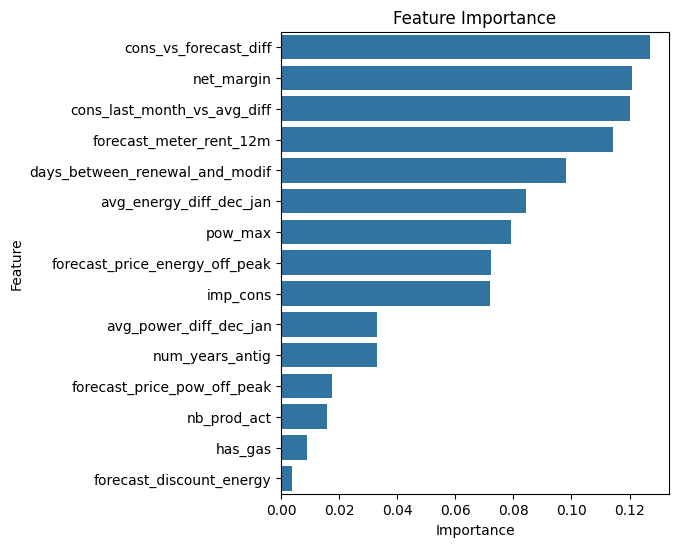

In [ ]:
features = [
    'forecast_discount_energy', 'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak', 'forecast_price_pow_off_peak',
    'imp_cons', 'nb_prod_act', 'has_gas',
    'net_margin', 'num_years_antig', 'pow_max', 'avg_energy_diff_dec_jan',
    'avg_power_diff_dec_jan','cons_vs_forecast_diff','days_between_renewal_and_modif',
    'cons_last_month_vs_avg_diff'
]
X = merged_df[features]
y = merged_df['churn']  # Convert churn to numerical

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))

# Feature Importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

## ***This code calculates the net savings from offering discounts to high-risk customers.***

In [ ]:
# Assumptions
initial_churn_rate = 0.097  # Initial churn rate (9.7%)
retention_rate_increase = 1  # Retention rate increase due to discount
discount_rate = 0.20  # Discount rate (20%)

# Number of high-risk customers identified by the model
num_high_risk_customers = len(merged_df[merged_df['churn'] == 1])

# Net margin for high-risk customers
net_margin_high_risk_customers = merged_df[merged_df['churn'] == 1]['net_margin']

# Revenue retained (sum of net margins of retained customers)
retained_customers = num_high_risk_customers * retention_rate_increase
revenue_retained = net_margin_high_risk_customers.sum() * retention_rate_increase

# Cost of providing discounts (sum of net margins of retained customers multiplied by discount rate)
discount_cost = net_margin_high_risk_customers.sum() * discount_rate

# Net savings
net_savings = revenue_retained - discount_cost

print(f"Net Savings: {net_savings:.2f}")

Net Savings: 259236.47
